<a href="https://colab.research.google.com/github/Yoon0527/AIFFEL_Going_Deeper/blob/main/%5BGD_08%5D_Make_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [GD-08] GO/STOP! - Object Detection 시스템 만들기
object detection 모델을 통해 주변에 다른 차나 사람이 가까이 있는지 확인한 후 멈출 수 있는 자율주행 시스템을 만들어보자. 하지만 자율주행 시스템은 아직 완전하지 않기 때문에, 위험한 상황에서는 운전자가 직접 운전할 수 있도록 하거나 판단이 어려운 상황에서는 멈추도록 설계된다. 이와 같은 구조를 가진 미니 자율주행 보조 장치를 만들어 보자.

## 자율주행 보조장치 (1) KITTI 데이터셋
자율주행 보조장치는 카메라에 사람이 탐지되었을 때, 그리고 차가 가까워져서 탐지된 크기가 일정 크기 이상일 때를 판단해야 한다.
> **자율주행 보조장치 object detection 요구사항**
>
> * 사람이 카메라에 감지되면 정지
> * 차량이 일정 크기 이상으로 감지되면 정지

tensorflow_datasets에서 제공하는 KITTI 데이터셋을 사용하는데, KITTI 데이터셋은 자율주행을 위한 데이터셋으로 2D object detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공하고 있다.

In [ ]:
# gdrive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 필요한 라이브러리 불러오기
import copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# 데이터 경로 설정
DATA_PATH = '/content/drive/MyDrive/aiffel/gd-08/data'

In [ ]:
# KITTI 데이터셋 다운로드
(ds_train, ds_test), ds_info = tfds.load(
    'KITTI',
    data_dir = DATA_PATH,
    split = ['train', 'test'],
    shuffle_files = True,
    with_info = True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /content/drive/MyDrive/aiffel/gd-08/data/kitti/3.2.0.incomplete9Z2WGC/kitti-train.tfrecord


  0%|          | 0/6347 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /content/drive/MyDrive/aiffel/gd-08/data/kitti/3.2.0.incomplete9Z2WGC/kitti-validation.tfrecord


  0%|          | 0/423 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /content/drive/MyDrive/aiffel/gd-08/data/kitti/3.2.0.incomplete9Z2WGC/kitti-test.tfrecord


  0%|          | 0/711 [00:00<?, ? examples/s]

Dataset kitti downloaded and prepared to /content/drive/MyDrive/aiffel/gd-08/data/kitti/3.2.0. Subsequent calls will reuse this data.


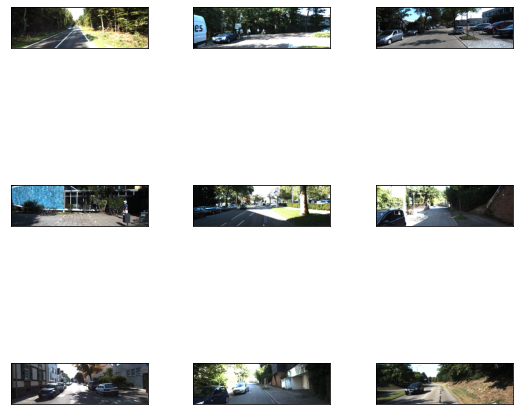

In [ ]:
# KITTI 데이터셋 확인
_ = tfds.show_examples(ds_train, ds_info)

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

## 자율주행 보조장치 (2) 데이터 직접 확인하기
ds_train.take(1)을 통해 데이터셋을 하나씩 뽑아볼 수 있는 sample을 얻을 수 있다. 이렇게 뽑은 데이터에는 image 등의 정보가 포함되어 있다.

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([-1.66, -1.73, -1.97, -1.86, -2.15], dtype=float32)>, 'bbox': <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.47544   , 0.51008856, 0.5314933 , 0.53008854],
       [0.37909332, 0.5438728 , 0.5161333 , 0.6001449 ],
       [0.07626667, 0.6376087 , 0.51034665, 0.86917067],
       [0.43810666, 0.595475  , 0.5300267 , 0.6442593 ],
       [0.14066666, 0.7127053 , 1.        , 0.99919486]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[1.42, 1.45, 3.2 ],
       [1.38, 1.49, 3.32],
       [1.5 , 1.62, 3.89],
       [1.44, 1.56, 3.96],
       [3.55, 2.56, 7.97]], dtype=float32)>, 'location': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[ 2.48,  1.64, 50.77],
       [ 2.85,  1.64, 21.29],
       [ 3.54,  1.65,  8.78],
       [ 7.09,  1.61, 32.5 ],
       [ 7.39,  1.63, 11.76]], dtype=float32)>, 'oc

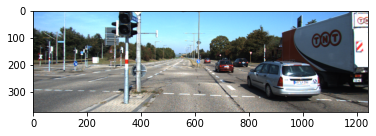

In [ ]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

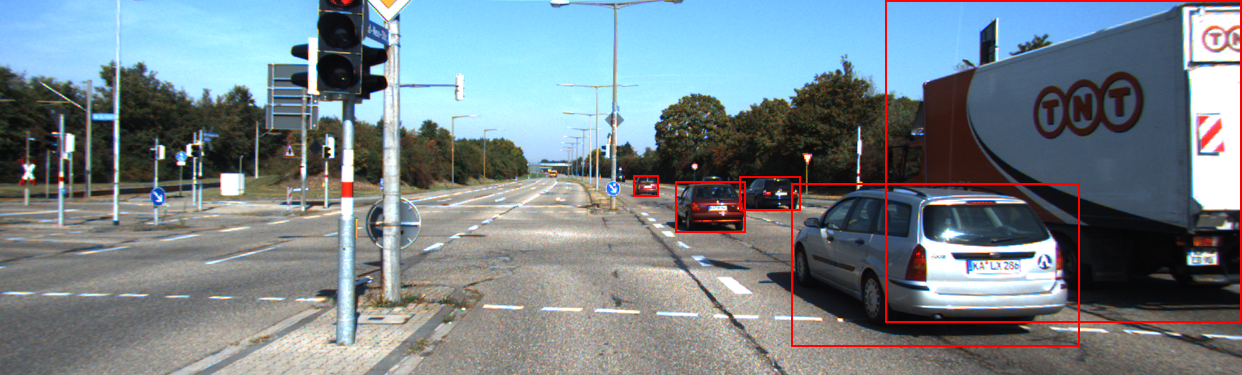

In [ ]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())